# Step 1. Load the data and import libraries. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import collections


# Other Libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

file_path = "../../bbd-payments-hackathon-2025/Payments Fraud DataSet/"


## The function to process all the data, both training and testing.

In [ ]:
# Merging the dataset
terminal_stats = None

def process_data_for_training(targetFile = 'transactions_train.csv', isTest = False):
    global terminal_stats
    customers_df = pd.read_csv(file_path + "customers.csv")
    merchants_df = pd.read_csv(file_path + "merchants.csv")
    terminals_df = pd.read_csv(file_path + "terminals.csv")
    transactions_df = pd.read_csv(file_path + targetFile)

    merged_train = transactions_df.copy()
    merged_train = merged_train.merge(customers_df, on='CUSTOMER_ID', how='left')
    merged_train = merged_train.merge(terminals_df, on='TERMINAL_ID', how='left')
    merged_train = merged_train.merge(merchants_df, on='MERCHANT_ID', how='left')

    merged_train.columns = merged_train.columns.str.upper()

    # Time-based Features

    def categorise_transaction_frequency(seconds):
        if pd.isna(seconds):
            return "first"
        elif seconds < 60:
            return "under_1_min"
        elif seconds < 3600:
            return "under_1_hour"
        elif seconds < 86400:
            return "under_1_day"
        elif seconds < 604800:
            return "under_1_week"
        elif seconds < 2.592e+6:
            return "under_1_month"
        elif seconds < 1.555e+7:
            return "under_6_months"
        else:
            return "over_6_months"

    def categorise_time_until_expiration(months):
        if months <= 0:
            return "expired"
        elif months < 1:
            return "under_1_month"
        elif months < 3:
            return "under_3_months"
        elif months < 6:
            return "under_6_months"
        elif months < 12:
            return "under_1_year"
        else:
            return "over_1_year"

    def months_until_expiry(row):
        return (row["CARD_EXPIRY_DATE"].year - row["TX_TS"].year) * 12 + \
            (row["CARD_EXPIRY_DATE"].month - row["TX_TS"].month)
    #NEW
    merged_train['original_index'] = merged_train.index

    merged_train["TX_TS"] = pd.to_datetime(merged_train["TX_TS"])
    merged_train["DAY_OF_WEEK"] = merged_train['TX_TS'].dt.day_of_week
    merged_train["HOUR"] = merged_train['TX_TS'].dt.hour
    merged_train["IS_WEEKEND"] = merged_train['TX_TS'].dt.day_of_week >= 5
    merged_train["DAY_OF_MONTH"] = merged_train['TX_TS'].dt.day.astype("category")
    merged_train_sorted = merged_train.sort_values(["CUSTOMER_ID", "TX_TS"])
    merged_train["TIME_SINCE_LAST_TRANSACTION"] = merged_train_sorted.groupby("CUSTOMER_ID")["TX_TS"].diff().dt.total_seconds()
    merged_train["IS_FIRST_TRANSACTION"] = merged_train["TIME_SINCE_LAST_TRANSACTION"].isna().astype(int)
    merged_train["TIME_SINCE_LAST_TRANSACTION"] = merged_train["TIME_SINCE_LAST_TRANSACTION"].fillna(0)
    merged_train["WINDOW_AFTER_LAST_TRANSACTION_CATEGORY"] = merged_train["TIME_SINCE_LAST_TRANSACTION"].apply(categorise_transaction_frequency).astype("category")
    merged_train["IS_BUSINESS_HOURS"] = (merged_train["TX_TS"].dt.hour >=8) | (merged_train["TX_TS"].dt.hour <=17)
    merged_train["CARD_EXPIRY_DATE"] = pd.to_datetime(
        "01/" + merged_train["CARD_EXPIRY_DATE"].astype(str), format="%d/%m/%y"
    )
    merged_train["CARD_EXPIRY_DATE"] = merged_train["CARD_EXPIRY_DATE"].dt.to_period('M').dt.end_time
    merged_train["MONTHS_UNTIL_EXPIRY"] = merged_train.apply(months_until_expiry, axis=1)
    merged_train["EXPIRY_CATEGORY"] = merged_train["MONTHS_UNTIL_EXPIRY"].apply(categorise_time_until_expiration).astype("category")

    #NEW
    merged_train = merged_train.sort_values(by=['CUSTOMER_ID', 'TX_TS'])

    customer_avg_amount = merged_train.groupby('CUSTOMER_ID')['TX_AMOUNT'].mean().reset_index()
    customer_avg_amount.rename(columns={'TX_AMOUNT': 'CUSTOMER_AVERAGE_AMOUNT'}, inplace=True)
    merged_train = merged_train.merge(customer_avg_amount, on='CUSTOMER_ID', how='left')

    merged_train['temp_unique_ts'] = merged_train['TX_TS'] + pd.to_timedelta(merged_train.groupby('TX_TS').cumcount(), unit='ms')

    merged_train['ROLLING_AVG_CUST_TX_7D'] = merged_train.set_index('temp_unique_ts').groupby('CUSTOMER_ID', group_keys=False).apply(
      lambda x: x['TX_AMOUNT'].rolling('7D').mean()
    )
    merged_train['ROLLING_COUNT_CUST_TX_7D'] = merged_train.set_index('temp_unique_ts').groupby('CUSTOMER_ID', group_keys=False).apply(
        lambda x: x['TX_AMOUNT'].rolling('7D').count()
    )

    merged_train = merged_train.sort_values(by='original_index').drop(columns=['original_index', 'temp_unique_ts'])

    # Interaction Feature
    merged_train['TX_AMOUNT_BY_CUSTOMER_CARD'] = merged_train['TX_AMOUNT'] / merged_train['CUSTOMER_AVERAGE_AMOUNT']
    merged_train.fillna({'TX_AMOUNT_BY_CUSTOMER_CARD': 0}, inplace=True)
    merged_train['TX_AMOUNT_BY_CUSTOMER_AVG'] = merged_train['TX_AMOUNT'] / merged_train['CUSTOMER_AVERAGE_AMOUNT']
    merged_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_train.fillna({'TX_AMOUNT_BY_CUSTOMER_AVG': 0}, inplace=True)

    # Geographical Features
    coord_cols = [col for col in merged_train.columns if any(coord in col for coord in ['X_', 'Y_'])]
    print(f"  Found coordinate columns: {coord_cols}")

    if len(coord_cols) >= 4:
        # Find customer and terminal coordinates
        customer_coords = [col for col in coord_cols if 'CUSTOMER' in col]
        terminal_coords = [col for col in coord_cols if 'TERMINAL' in col]

        if len(customer_coords) >= 2 and len(terminal_coords) >= 2:
            customer_x = [col for col in customer_coords if 'X' in col][0]
            customer_y = [col for col in customer_coords if 'Y' in col][0]
            terminal_x = [col for col in terminal_coords if 'X' in col][0]
            terminal_y = [col for col in terminal_coords if 'Y' in col][0]

            # Distance calculations
            merged_train['EUCLIDEAN_DISTANCE'] = np.sqrt(
                (merged_train[customer_x] - merged_train[terminal_x])**2 +
                (merged_train[customer_y] - merged_train[terminal_y])**2
            )

            merged_train['MANHATTAN_DISTANCE'] = (
                abs(merged_train[customer_x] - merged_train[terminal_x]) +
                abs(merged_train[customer_y] - merged_train[terminal_y])
            )

            # Distance categories
            merged_train['DISTANCE_CATEGORY'] = pd.cut(merged_train['EUCLIDEAN_DISTANCE'],
                                                bins=[0, 10, 25, 50, 100, float('inf')],
                                                labels=['very_close', 'close', 'medium', 'far', 'very_far'])

            # Quadrant analysis
            merged_train['CUSTOMER_QUADRANT'] = (
                (merged_train[customer_x] >= 50).astype(int) * 2 +
                (merged_train[customer_y] >= 50).astype(int)
            )

            merged_train['TERMINAL_QUADRANT'] = (
                (merged_train[terminal_x] >= 50).astype(int) * 2 +
                (merged_train[terminal_y] >= 50).astype(int)
            )

            merged_train['SAME_QUADRANT'] = (merged_train['CUSTOMER_QUADRANT'] == merged_train['TERMINAL_QUADRANT']).astype(int)
        else:
            print(f"  Insufficient coordinate data")

# We get terminal aggregate features since we noticed that terminal location is a big indicator of fraud
    if (isTest == False):
        terminal_stats = (
            merged_train.groupby("TERMINAL_ID")["TX_FRAUD"]
            .agg(["mean", "sum", "count"])
            .reset_index()
            .rename(columns={
                "mean": "TERMINAL_FRAUD_RATE",
                "sum": "TERMINAL_FRAUD_COUNT",
                "count": "TERMINAL_TX_COUNT"
            })
        )

        merged_train = merged_train.merge(terminal_stats, on="TERMINAL_ID", how="left")
    else:
        # Use precomputed stats (must exist already)
        if terminal_stats is None:
            raise ValueError("terminal_stats not initialized. Run on training data first.")

        merged_train = merged_train.merge(terminal_stats, on="TERMINAL_ID", how="left")

        # Fill missing values for unseen terminals
        merged_train.fillna({
            "TERMINAL_FRAUD_RATE": 0,  # or global fraud rate
            "TERMINAL_FRAUD_COUNT": 0,
            "TERMINAL_TX_COUNT": 0
        }, inplace=True)

    # We do some dropping of columns and conversions to category for LightGBM
    drop_cols = []
    if (isTest):
        drop_cols = [
            'CARD_DATA',
            'CUSTOMER_ID',
            'TERMINAL_ID',
            'MERCHANT_ID',
            'TX_TS',
            'CARD_EXPIRY_DATE',
            'ACQUIRER_ID',
            'LEGAL_NAME',
            'X_TERMINAL_ID',
            'Y_TERMINAL__ID'
        ]
    else:
        drop_cols = [
            'TX_ID',
            'CARD_DATA',
            'CUSTOMER_ID',
            'TERMINAL_ID',
            'MERCHANT_ID',
            'TX_TS',
            'CARD_EXPIRY_DATE',
            'ACQUIRER_ID',
            'LEGAL_NAME',
            'X_TERMINAL_ID',
            'Y_TERMINAL__ID'
        ]
    merged_train = merged_train.drop(columns=drop_cols, errors='ignore')

    categorical_cols = [
        'CARD_BRAND', 'TRANSACTION_TYPE', 'TRANSACTION_STATUS',
        'FAILURE_CODE', 'BUSINESS_TYPE', 'OUTLET_TYPE',
        'DAY_OF_MONTH', 'WINDOW_AFTER_LAST_TRANSACTION_CATEGORY',
        'EXPIRY_CATEGORY', 'DISTANCE_CATEGORY', 'CARD_COUNTRY_CODE', 'IS_RECURRING_TRANSACTION', 'CARDHOLDER_AUTH_METHOD', 'TRANSACTION_CURRENCY' ,'FAILURE_REASON','TAX_EXCEMPT_INDICATOR'
    ]

    for col in categorical_cols:
        if col in merged_train.columns:
            merged_train[col] = merged_train[col].astype('category')

    bool_cols = merged_train.select_dtypes(include='bool').columns
    merged_train[bool_cols] = merged_train[bool_cols].astype(int)

    for date_col in ['FOUNDATION_DATE', 'ACTIVE_FROM', 'TRADING_FROM']:
        if date_col in merged_train.columns:
            merged_train[date_col] = pd.to_datetime(merged_train[date_col], errors='coerce')
            merged_train[f'{date_col}_AGE_DAYS'] = (pd.to_datetime('2021-12-07') - merged_train[date_col]).dt.days
            merged_train = merged_train.drop(columns=[date_col])
    print("Final feature set:")
    print(merged_train.dtypes)
    print("Number of features:", merged_train.shape[1])

    return merged_train

## Now we set up the training and testing

In [6]:
merged_train = process_data_for_training("transactions_train.csv", False)
merged_test = process_data_for_training("transactions_test.csv", True)

  Found coordinate columns: ['TX_ID', 'TX_TS', 'TX_AMOUNT', 'TX_FRAUD', 'CARD_EXPIRY_DATE', 'CARD_COUNTRY_CODE', 'X_CUSTOMER_ID', 'Y_CUSTOMER_ID', 'X_TERMINAL_ID', 'Y_TERMINAL__ID', 'TAX_EXCEMPT_INDICATOR', 'DELIVERY_SAME_DAYS_PERCENTAGE', 'DELIVERY_WEEK_ONE_PERCENTAGE', 'DELIVERY_WEEK_TWO_PERCENTAGE', 'DELIVERY_OVER_TWO_WEEKS_PERCENTAGE', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'EXPIRY_CATEGORY', 'ROLLING_AVG_CUST_TX_7D', 'ROLLING_COUNT_CUST_TX_7D', 'TX_AMOUNT_BY_CUSTOMER_CARD', 'TX_AMOUNT_BY_CUSTOMER_AVG']
Final feature set:
TX_AMOUNT                                  float64
TX_FRAUD                                     int64
TRANSACTION_GOODS_AND_SERVICES_AMOUNT      float64
TRANSACTION_CASHBACK_AMOUNT                float64
CARD_BRAND                                category
TRANSACTION_TYPE                          category
TRANSACTION_STATUS                        category
FAILURE_CODE                              category
FAILURE_REASON                            category
TRANSACTION_CURRE

## Now we do the splitting. We use K_fold for cross_validation

In [7]:
from sklearn.model_selection import train_test_split

print('No Frauds', round(merged_train['TX_FRAUD'].value_counts()[0]/len(merged_train) * 100,2), '% of the dataset')
print('Frauds', round(merged_train['TX_FRAUD'].value_counts()[1]/len(merged_train) * 100,2), '% of the dataset')

X = merged_train.drop('TX_FRAUD', axis=1)
y = merged_train['TX_FRAUD']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 97.42 % of the dataset
Frauds 2.58 % of the dataset
Train: [ 213040  213041  213042 ... 1066437 1066438 1066439] Test: [     0      1      2 ... 222465 222502 222522]
Train: [      0       1       2 ... 1066437 1066438 1066439] Test: [213040 213041 213042 ... 440341 440350 440391]
Train: [      0       1       2 ... 1066437 1066438 1066439] Test: [426199 426200 426201 ... 656605 656669 656776]
Train: [      0       1       2 ... 1066437 1066438 1066439] Test: [639440 639441 639442 ... 855995 856017 856045]
Train: [     0      1      2 ... 855995 856017 856045] Test: [ 853066  853067  853068 ... 1066437 1066438 1066439]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.97415349 0.02584651]
[0.97415232 0.02584768]


## Lets implement random under sampling

In [8]:
merged_train = merged_train.sample(frac=1)

# amount of fraud classes 27567 rows.
fraud_merged_train = merged_train.loc[merged_train['TX_FRAUD'] == 1]
non_fraud_merged_train = merged_train.loc[merged_train['TX_FRAUD'] == 0][:27567]

normal_distributed_merged_train = pd.concat([fraud_merged_train, non_fraud_merged_train])

# Shuffle dataframe rows
new_merged_train = normal_distributed_merged_train.sample(frac=1, random_state=42)

print('Distribution of the Classes in the subsample dataset')
print(new_merged_train['TX_FRAUD'].value_counts()/len(new_merged_train))

Distribution of the Classes in the subsample dataset
TX_FRAUD
0    0.500027
1    0.499973
Name: count, dtype: float64


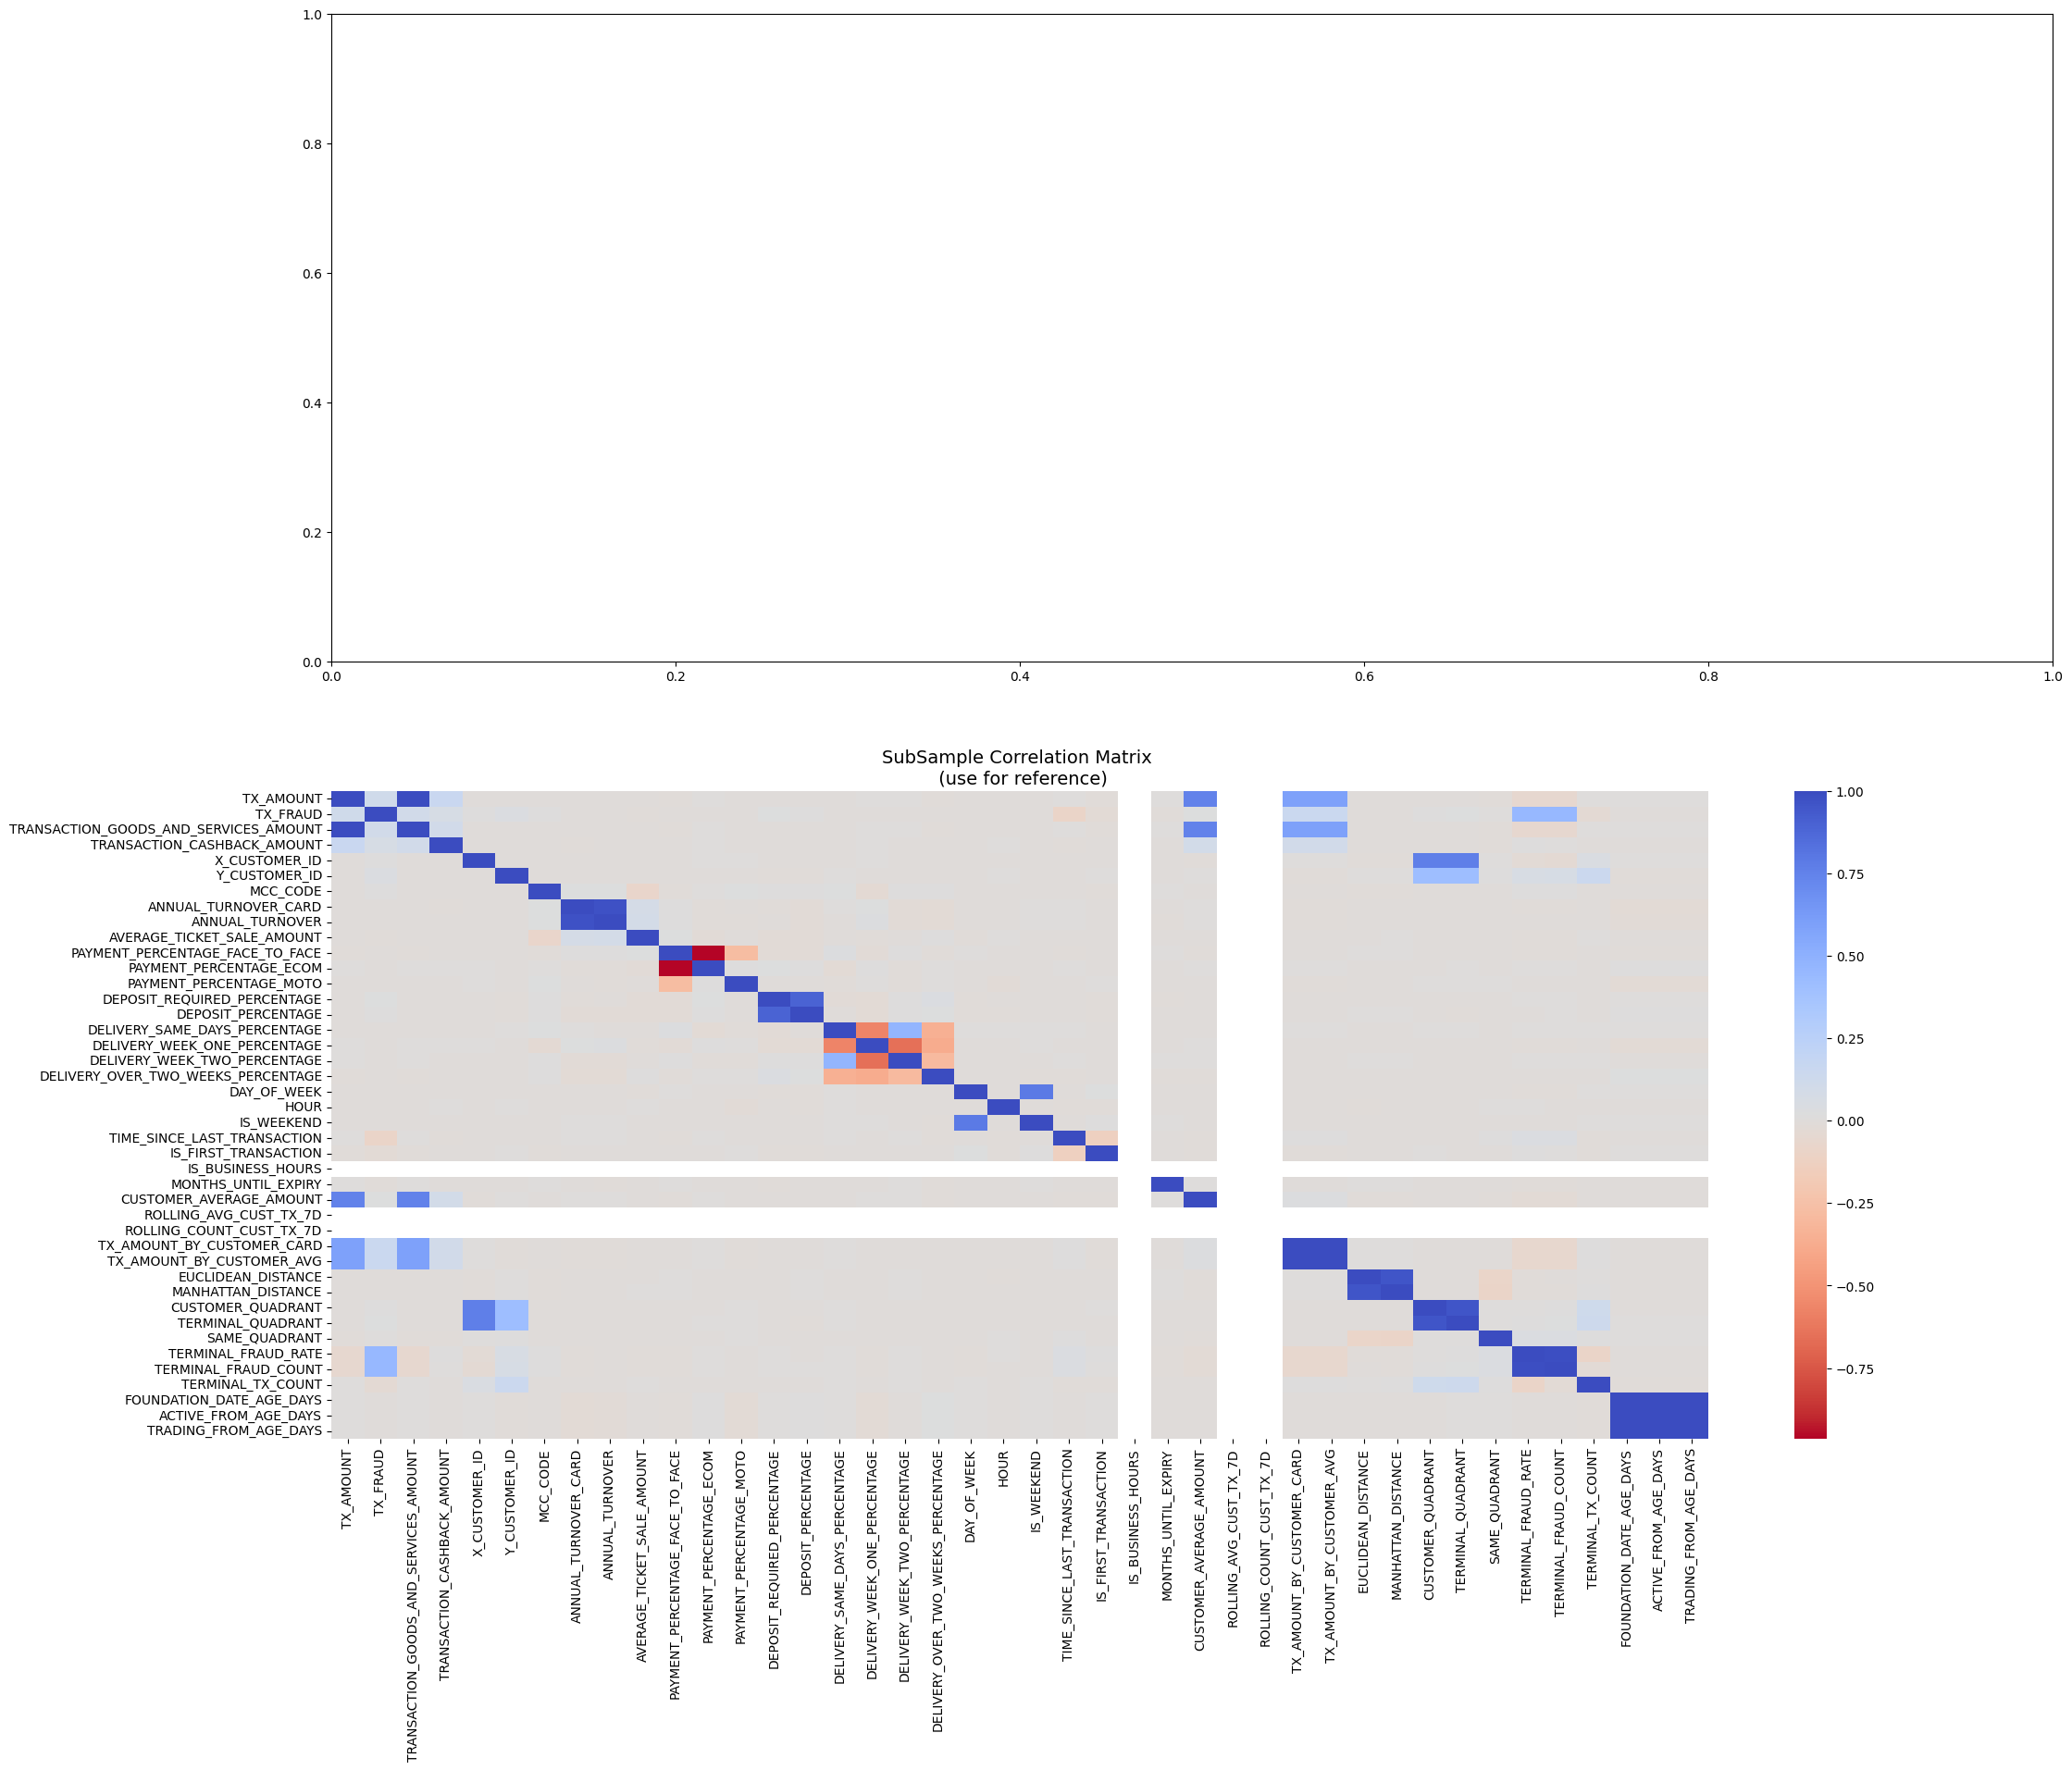

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

sub_sample_corr = new_merged_train.select_dtypes(include=['number']).corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [10]:
print(new_merged_train.dtypes)

TX_AMOUNT                                  float64
TX_FRAUD                                     int64
TRANSACTION_GOODS_AND_SERVICES_AMOUNT      float64
TRANSACTION_CASHBACK_AMOUNT                float64
CARD_BRAND                                category
TRANSACTION_TYPE                          category
TRANSACTION_STATUS                        category
FAILURE_CODE                              category
FAILURE_REASON                            category
TRANSACTION_CURRENCY                      category
CARD_COUNTRY_CODE                         category
IS_RECURRING_TRANSACTION                  category
CARDHOLDER_AUTH_METHOD                    category
X_CUSTOMER_ID                              float64
Y_CUSTOMER_ID                              float64
BUSINESS_TYPE                             category
MCC_CODE                                     int64
TAX_EXCEMPT_INDICATOR                     category
OUTLET_TYPE                               category
ANNUAL_TURNOVER_CARD           

In [11]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import numpy as np

X = new_merged_train.drop("TX_FRAUD", axis=1)
y = new_merged_train["TX_FRAUD"]

categorical_features = X.select_dtypes("category").columns.tolist()
n_splits = 5
sss = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

metrics = {
    "fold": [],
    "roc_auc": [],
    "f1": [],
    "precision": [],
    "recall": []
}

models = []
for fold, (train_idx, val_idx) in enumerate(sss.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(
        n_estimators=5000,          # Large number, will rely on early stopping
    learning_rate=0.02,         # Small learning rate → better generalization
    max_depth=10,               # Slightly deeper trees for complex patterns
    num_leaves=128,             # More leaves to capture subtle splits
    min_child_samples=30,       # Minimum samples per leaf → helps prevent overfitting
    subsample=0.8,              # Row sampling → adds randomness, reduces overfit
    colsample_bytree=0.8,       # Feature sampling per tree → adds robustness
    reg_alpha=2.0,              # L1 regularization → reduces overfitting
    reg_lambda=2.0,             # L2 regularization → reduces overfitting
    scale_pos_weight=2,        # Handle imbalance (fraud is rare). Adjust based on ratio
    random_state=42
    )

    # Correct way to use early stopping with callbacks
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        categorical_feature=categorical_features,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
    )

    models.append(model)

    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    roc = roc_auc_score(y_val, y_proba)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    metrics["fold"].append(fold)
    metrics["roc_auc"].append(roc)
    metrics["f1"].append(f1)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)

    print(f"Fold {fold} — ROC AUC: {roc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("\nAverage metrics over all folds:")
for metric_name in ["roc_auc", "f1", "precision", "recall"]:
    print(f"{metric_name}: {np.mean(metrics[metric_name]):.4f}")


[LightGBM] [Info] Number of positive: 22051, number of negative: 22053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5806
[LightGBM] [Info] Number of data points in the train set: 44104, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499977 -> initscore=-0.000091
[LightGBM] [Info] Start training from score -0.000091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## Lets get some information about the importance of the features

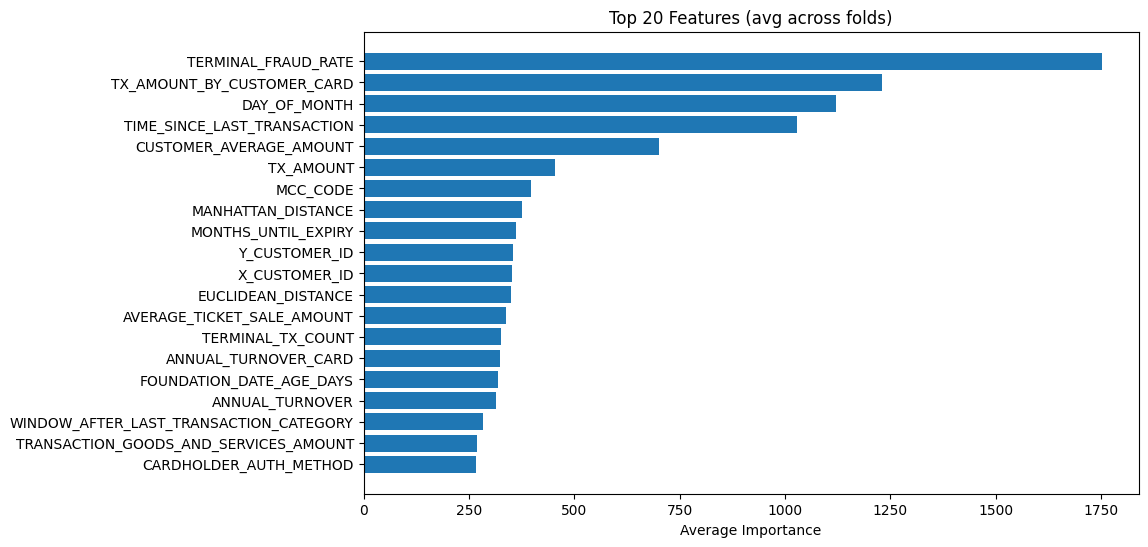

In [12]:
feature_importances = pd.DataFrame({
    "feature": X.columns,
    "importance": np.mean([m.feature_importances_ for m in models], axis=0)
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["feature"][:20][::-1],
         feature_importances["importance"][:20][::-1])
plt.xlabel("Average Importance")
plt.title("Top 20 Features (avg across folds)")
plt.show()

What does the above graph mean? It means that surprisingly the location of the terminal is a big red flag for fraud likelihood. Perhaps some terminals are being abused by fraudsters OR certain target businesses that use these terminals are targets.

# Now we use it to get predictions!!

## This block will use a single strong model thats trained on all the undersampling data.

In [13]:
X_full = new_merged_train.drop("TX_FRAUD", axis=1)
y_full = new_merged_train["TX_FRAUD"]

categorical_features = X_full.select_dtypes("category").columns.tolist()

final_model = lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.03,
    max_depth=10,
    num_leaves=128,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    scale_pos_weight=2,
    random_state=42
)

final_model.fit(
    X_full, y_full,
    categorical_feature=categorical_features
)

print(merged_test.columns)
print(merged_train.columns)

X_test = merged_test[X_full.columns]
pred_proba = model.predict_proba(X_test)[:, 1]

predictions = pd.DataFrame({
    "TX_ID": merged_test["TX_ID"],
    "prediction": pred_proba
})

predictions.to_csv("lightGBM_predictions.csv", index=False)

print("✅ Predictions saved to predictions.csv")

[LightGBM] [Info] Number of positive: 27564, number of negative: 27567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5808
[LightGBM] [Info] Number of data points in the train set: 55131, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499973 -> initscore=-0.000109
[LightGBM] [Info] Start training from score -0.000109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

## This block will use an ensemble method with the 5 methods we created during cross-validation

In [14]:
X_test = merged_test[X_full.columns]
preds = np.zeros(X_test.shape[0])

for model in models:
    preds += model.predict_proba(X_test)[:, 1]

preds /= len(models)  # average probabilities

# ----------------------------
# 3️⃣ Save to CSV
# ----------------------------
predictions = pd.DataFrame({
    "TX_ID": merged_test["TX_ID"],
    "TX_FRAUD": preds
})

predictions.to_csv("lightGBM_predictions_ensemble.csv", index=False)

print("✅ Ensemble predictions saved to predictions_ensemble.csv")

✅ Ensemble predictions saved to predictions_ensemble.csv
